In [ ]:
"""
Predict generation of the second PV inverter (INV2) with help of the ideal sine waveform.
Frequency: Calculated with a FFT and the actual times for sunrise / sunset
Amplitude: Calculated by the max of the previous day --> scaling for the sine
Zero Phases: (t < sunrise) and (t > sunset) != 0
"""

In [2]:
# Imports
import sys
sys.path.append('../')
sys.path.append('../../')
from imports import *

print(sys.path)

['x:\\git\\LRZ\\masters-thesis\\prediction\\sine', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310', '', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin', '../']


IoT Server at 100.113.141.113 initialized
+---------------------+-------------------------------------------------+
|        Field        |                      Value                      |
+---------------------+-------------------------------------------------+
|          IP         |                 100.113.141.113                 |
|       Devices       |             ['INV2', 'TEMP', 'HUM']             |
|      Time (abs)     | 2024-08-24T00:00:00Z < t < 2024-08-25T00:00:00Z |
|      Time (rel)     |                       None                      |
|      Time (res)     |                        1m                       |
| Prediction horizont |                      15 min                     |
|      Delimiter      |                        ;                        |
|         CWD         |    x:\git\LRZ\masters-thesis\prediction\sine    |
|     Backend Port    |                       5000                      |
|     Backend Path    |                  download-file                

<AxesSubplot: xlabel='Date'>

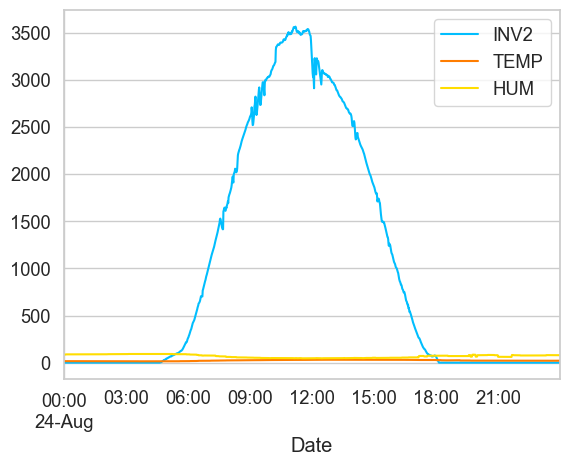

In [3]:
# Specify the IoT Server interface --> only working within the Tailscale VPN connection
ip = "100.113.141.113"
devices = ["INV2", "TEMP", "HUM"] # First device defines the value to be forecasted
# time_abs_start = "2024-06-18T00:00:00Z"
# time_abs_end   = "2024-06-19T00:00:00Z"
time_abs_start = "2024-08-24T00:00:00Z"
time_abs_end   = "2024-08-25T00:00:00Z"

time_range = "None"
res = "1m"

# Day before --> basis for prediction
prev_iot_server = IotGrabber(
                          ip=ip,
                          devices=devices,
                          time_abs_start=time_abs_start,
                          time_abs_end=time_abs_end,
                          range=time_range,
                          res=res,
                          delimiter=";",
                          cwd=os.getcwd()
                          )

print(prev_iot_server)
df = prev_iot_server.get_df()
# prev_df.plot()

tum_lat  = 48.267410
tum_long = 11.668265


sine_fitting = SineFitting(
    date=time_abs_start, 
    latitude=tum_lat, 
    longitude=tum_long,
    previous_df=df )
# sine_fitting.set_previous_day(df)

INV2_modeled = sine_fitting.calc_sine()
# dINV2 = sine_fitting.calc_d()

df.plot()



RMSE: 72.39499959543483
                    Date  INV2  Sine  dINV2
0    2024-08-24 00:00:00   0.0   0.0    0.0
1    2024-08-24 00:01:00   0.0   0.0    0.0
2    2024-08-24 00:02:00   0.0   0.0    0.0
3    2024-08-24 00:03:00   0.0   0.0    0.0
4    2024-08-24 00:04:00   0.0   0.0    0.0
...                  ...   ...   ...    ...
1435 2024-08-24 23:55:00   0.0   0.0    0.0
1436 2024-08-24 23:56:00   0.0   0.0    0.0
1437 2024-08-24 23:57:00   0.0   0.0    0.0
1438 2024-08-24 23:58:00   0.0   0.0    0.0
1439 2024-08-24 23:59:00   0.0   0.0    0.0

[1440 rows x 4 columns]


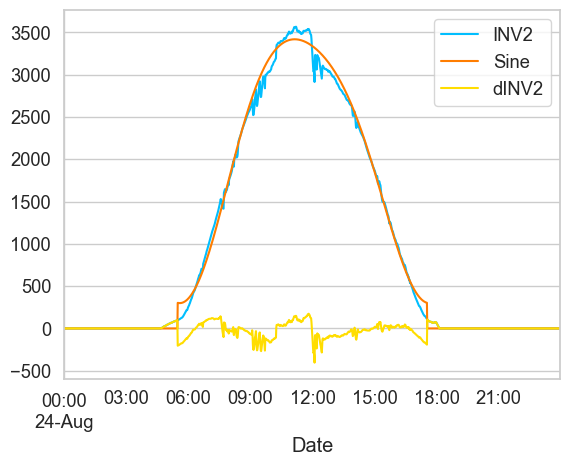

In [4]:
# Calculate absolute deviation between the real values and the sine prediction from the day before
dPredicitionWithSine = df.INV2.values - INV2_modeled

# Sum everything in a pandas df
df_computed = pd.DataFrame()
df_computed.insert(0, "Date", df.index.values)
df_computed.insert(1, "INV2", df.INV2.values)
df_computed.insert(2, "Sine", INV2_modeled)
df_computed.insert(3, "dINV2", dPredicitionWithSine)
df_computed.set_index("Date")
df_computed.to_csv("sine-prediction-compareSameDay.csv", sep=";")

# Calc RMSE value
rmse_sine = calc_rmse(df_computed.INV2, df_computed.Sine)

# Plot
df_computed.plot(x=0)
print(f"RMSE: {rmse_sine}")
with open("rmse-calc.txt", "w+") as f:
    f.write(f"{rmse_sine}")
print(df_computed)

In [7]:
max(df.INV2.values)

3568.50244140625